# 基于LSTM+Attention的石油产量预测模型(PyTorch Vision)

## 导入必要的库


使用随机种子确保实验可复现

In [172]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## 数据分析与处理

### 读取数据

In [173]:
# 读取数据
full_data = pd.read_excel('Volve_production_data.xlsx')
full_data.head()

,DATEPRD,WELL_BORE_CODE,NPD_WELL_BORE_CODE,NPD_WELL_BORE_NAME,NPD_FIELD_CODE,NPD_FIELD_NAME,NPD_FACILITY_CODE,NPD_FACILITY_NAME,ON_STREAM_HRS,AVG_DOWNHOLE_PRESSURE,...,AVG_CHOKE_UOM,AVG_WHP_P,AVG_WHT_P,DP_CHOKE_SIZE,BORE_OIL_VOL,BORE_GAS_VOL,BORE_WAT_VOL,BORE_WI_VOL,FLOW_KIND,WELL_TYPE
0,2014-04-07,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,0.00000,...,%,0.00000,0.00000,0.00000,0.0,0.0,0.0,NaN,production,WI
1,2014-04-08,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,NaN,...,%,0.00000,0.00000,0.00000,0.0,0.0,0.0,NaN,production,OP
2,2014-04-09,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,NaN,...,%,0.00000,0.00000,0.00000,0.0,0.0,0.0,NaN,production,OP
3,2014-04-10,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,NaN,...,%,0.00000,0.00000,0.00000,0.0,0.0,0.0,NaN,production,OP
4,2014-04-11,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,310.37614,...,%,33.09788,10.47992,33.07195,0.0,0.0,0.0,NaN,production,OP


### 查看列名

In [174]:
column_names = full_data.columns
print(column_names)

Index(['DATEPRD', 'WELL_BORE_CODE', 'NPD_WELL_BORE_CODE', 'NPD_WELL_BORE_NAME',
       'NPD_FIELD_CODE', 'NPD_FIELD_NAME', 'NPD_FACILITY_CODE',
       'NPD_FACILITY_NAME', 'ON_STREAM_HRS', 'AVG_DOWNHOLE_PRESSURE',
       'AVG_DOWNHOLE_TEMPERATURE', 'AVG_DP_TUBING', 'AVG_ANNULUS_PRESS',
       'AVG_CHOKE_SIZE_P', 'AVG_CHOKE_UOM', 'AVG_WHP_P', 'AVG_WHT_P',
       'DP_CHOKE_SIZE', 'BORE_OIL_VOL', 'BORE_GAS_VOL', 'BORE_WAT_VOL',
       'BORE_WI_VOL', 'FLOW_KIND', 'WELL_TYPE'],
      dtype='object')


In [175]:
unique_well_bore = full_data['NPD_WELL_BORE_NAME'].unique()
print("All Unique Well Bore Names:")
print(unique_well_bore)

unique_producer_well_bore = full_data[full_data['FLOW_KIND'] == 'production']['NPD_WELL_BORE_NAME'].unique()
print("\nWell Bore Names for 'production':")
print(unique_producer_well_bore)

unique_injection_well_bore = full_data[full_data['FLOW_KIND'] == 'injection']['NPD_WELL_BORE_NAME'].unique()
print("\nWell Bore Names for 'injection':")
print(unique_injection_well_bore)

All Unique Well Bore Names:
['15/9-F-1 C' '15/9-F-11' '15/9-F-12' '15/9-F-14' '15/9-F-15 D' '15/9-F-4'
 '15/9-F-5']

Well Bore Names for 'production':
['15/9-F-1 C' '15/9-F-11' '15/9-F-12' '15/9-F-14' '15/9-F-15 D' '15/9-F-5']

Well Bore Names for 'injection':
['15/9-F-4' '15/9-F-5']


### 按时序对数据进行排序

In [176]:
full_data = full_data.sort_values(by='DATEPRD')
full_data

,DATEPRD,WELL_BORE_CODE,NPD_WELL_BORE_CODE,NPD_WELL_BORE_NAME,NPD_FIELD_CODE,NPD_FIELD_NAME,NPD_FACILITY_CODE,NPD_FACILITY_NAME,ON_STREAM_HRS,AVG_DOWNHOLE_PRESSURE,...,AVG_CHOKE_UOM,AVG_WHP_P,AVG_WHT_P,DP_CHOKE_SIZE,BORE_OIL_VOL,BORE_GAS_VOL,BORE_WAT_VOL,BORE_WI_VOL,FLOW_KIND,WELL_TYPE
12328,2007-09-01,NO 15/9-F-5 AH,5769,15/9-F-5,3420717,VOLVE,369304,MÆRSK INSPIRER,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,injection,WI
9001,2007-09-01,NO 15/9-F-4 AH,5693,15/9-F-4,3420717,VOLVE,369304,MÆRSK INSPIRER,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,injection,WI
12329,2007-09-02,NO 15/9-F-5 AH,5769,15/9-F-5,3420717,VOLVE,369304,MÆRSK INSPIRER,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,injection,WI
9002,2007-09-02,NO 15/9-F-4 AH,5693,15/9-F-4,3420717,VOLVE,369304,MÆRSK INSPIRER,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,injection,WI
9003,2007-09-03,NO 15/9-F-4 AH,5693,15/9-F-4,3420717,VOLVE,369304,MÆRSK INSPIRER,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,injection,WI
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12323,2016-10-05,NO 15/9-F-4 AH,5693,15/9-F-4,3420717,VOLVE,369304,MÆRSK INSPIRER,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,injection,WI
12324,2016-10-06,NO 15/9-F-4 AH,5693,15/9-F-4,3420717,VOLVE,369304,MÆRSK INSPIRER,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,injection,WI
12325,2016-10-07,NO 15/9-F-4 AH,5693,15/9-F-4,3420717,VOLVE,369304,MÆRSK INSPIRER,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,injection,WI
12326,2016-11-01,NO 15/9-F-4 AH,5693,15/9-F-4,3420717,VOLVE,369304,MÆRSK INSPIRER,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,injection,WI


### 定义使用数据

In [177]:
# F-12 data
data = full_data[(full_data['NPD_WELL_BORE_NAME'] == '15/9-F-12')][[
    'DATEPRD', 'ON_STREAM_HRS', 'AVG_DOWNHOLE_PRESSURE',
    'AVG_DOWNHOLE_TEMPERATURE', 'AVG_DP_TUBING', 'AVG_ANNULUS_PRESS',
    'AVG_CHOKE_SIZE_P', 'AVG_WHP_P', 'AVG_WHT_P', 'DP_CHOKE_SIZE',
    'BORE_OIL_VOL'
]]

# Full data
# data = full_data[['DATEPRD', 'ON_STREAM_HRS', 'AVG_DOWNHOLE_PRESSURE', 'AVG_DOWNHOLE_TEMPERATURE', 'AVG_DP_TUBING', 'AVG_ANNULUS_PRESS', 'AVG_CHOKE_SIZE_P', 'AVG_WHP_P', 'AVG_WHT_P', 'DP_CHOKE_SIZE', 'BORE_OIL_VOL']]

In [178]:
print(f'样本数量: {data.shape[0]} samples')

样本数量: 3056 samples


### 数据处理

In [179]:
null_values = data.isnull().sum()
print("Null values:")
print(null_values)

Null values:
DATEPRD                      0
ON_STREAM_HRS                0
AVG_DOWNHOLE_PRESSURE        6
AVG_DOWNHOLE_TEMPERATURE     6
AVG_DP_TUBING                6
AVG_ANNULUS_PRESS           13
AVG_CHOKE_SIZE_P            44
AVG_WHP_P                    0
AVG_WHT_P                    0
DP_CHOKE_SIZE                0
BORE_OIL_VOL                 0
dtype: int64


In [180]:
data = data.dropna()
null_values = data.isnull().sum()
print("Null values:")
print(null_values)

Null values:
DATEPRD                     0
ON_STREAM_HRS               0
AVG_DOWNHOLE_PRESSURE       0
AVG_DOWNHOLE_TEMPERATURE    0
AVG_DP_TUBING               0
AVG_ANNULUS_PRESS           0
AVG_CHOKE_SIZE_P            0
AVG_WHP_P                   0
AVG_WHT_P                   0
DP_CHOKE_SIZE               0
BORE_OIL_VOL                0
dtype: int64


### 数据可视化

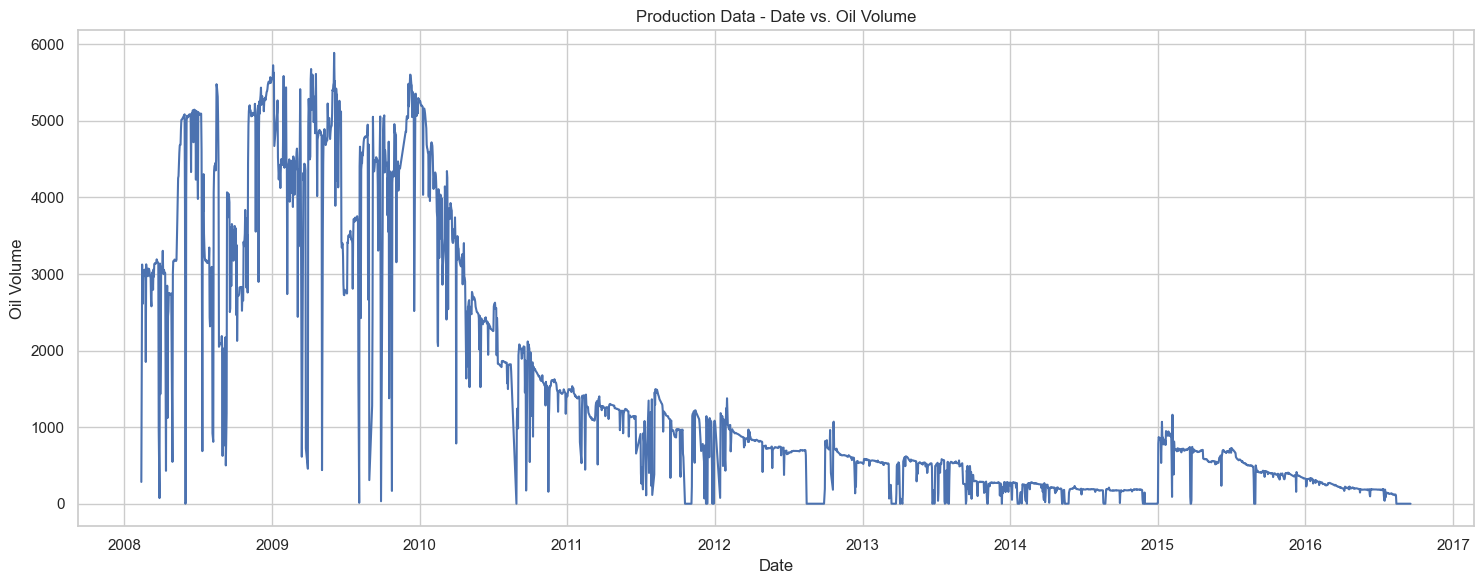

In [181]:
sns.set(style="whitegrid")
plt.figure(figsize=(15, 6))
sns.lineplot(data=data, x='DATEPRD', y='BORE_OIL_VOL', errorbar=None)
plt.xlabel('Date')
plt.ylabel('Oil Volume')
plt.title('Production Data - Date vs. Oil Volume')
plt.tight_layout()
plt.show()

### 数据预处理

#### 使用sklearn的MinMaxScaler缩放特征

In [182]:
torch.manual_seed(42)
from sklearn.preprocessing import MinMaxScaler

columns_to_scale = ['ON_STREAM_HRS', 'AVG_DOWNHOLE_PRESSURE', 'AVG_DOWNHOLE_TEMPERATURE', 'AVG_DP_TUBING', 'AVG_ANNULUS_PRESS', 'AVG_CHOKE_SIZE_P', 'AVG_WHP_P', 'AVG_WHT_P', 'DP_CHOKE_SIZE', 'BORE_OIL_VOL']
data_to_scale = data[columns_to_scale].copy()
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data_to_scale)
data_scaled_df = pd.DataFrame(data_scaled, columns=columns_to_scale)

# Add the 'DATEPRD' column as the first column. Later, we will use it for plotting purpose.
data_scaled_df.insert(0, 'DATEPRD', data['DATEPRD'])
data_scaled_df.head()

,DATEPRD,ON_STREAM_HRS,AVG_DOWNHOLE_PRESSURE,AVG_DOWNHOLE_TEMPERATURE,AVG_DP_TUBING,AVG_ANNULUS_PRESS,AVG_CHOKE_SIZE_P,AVG_WHP_P,AVG_WHT_P,DP_CHOKE_SIZE,BORE_OIL_VOL
0,NaT,0.460,0.978644,0.971263,0.719611,0.620908,0.144844,0.777839,0.176238,0.745028,0.048338
1,NaT,0.960,0.962689,0.980421,0.651296,0.548525,0.228330,0.880400,0.577278,0.722027,0.317507
2,NaT,0.900,0.939029,0.983889,0.650306,0.421708,0.312500,0.828179,0.786705,0.645493,0.530524
3,NaT,0.926,0.945627,0.983669,0.646602,0.175352,0.285189,0.850847,0.757051,0.678770,0.442930
4,NaT,0.960,0.940140,0.984220,0.645418,0.412548,0.302279,0.840679,0.773517,0.663528,0.518248


In [183]:
features_df = data_scaled_df[columns_to_scale]
target_df = data_scaled_df[['BORE_OIL_VOL']] # Target is the scaled oil volume

# 将数据转换为Numpy类型，便于LSTM进行处理 对于PyTorch来说这样是否是必要的？？？
features_np = features_df.to_numpy()
target_np = target_df.to_numpy()

### 划分训练集、验证集、测试集

从全部数据中取`70%`数据作为训练数据，再从`30%`的测试数据中取一半的数据为验证集。最终训练集，验证集，测试集分别占总数据的`70%，15%，15%`。

In [184]:
from sklearn.model_selection import train_test_split

X_train, X_temp, Y_train, Y_temp = train_test_split(features_np, target_np, test_size=0.3, shuffle=False)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, shuffle=False)
X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_val = np.array(X_val)
Y_val = np.array(Y_val)
X_test = np.array(X_test)
Y_test = np.array(Y_test)

print("训练集样本数:", X_train.shape[0])
print("验证集样本数:", X_val.shape[0])
print("测试集样本数:", X_test.shape[0])

训练集样本数: 2095
验证集样本数: 449
测试集样本数: 449


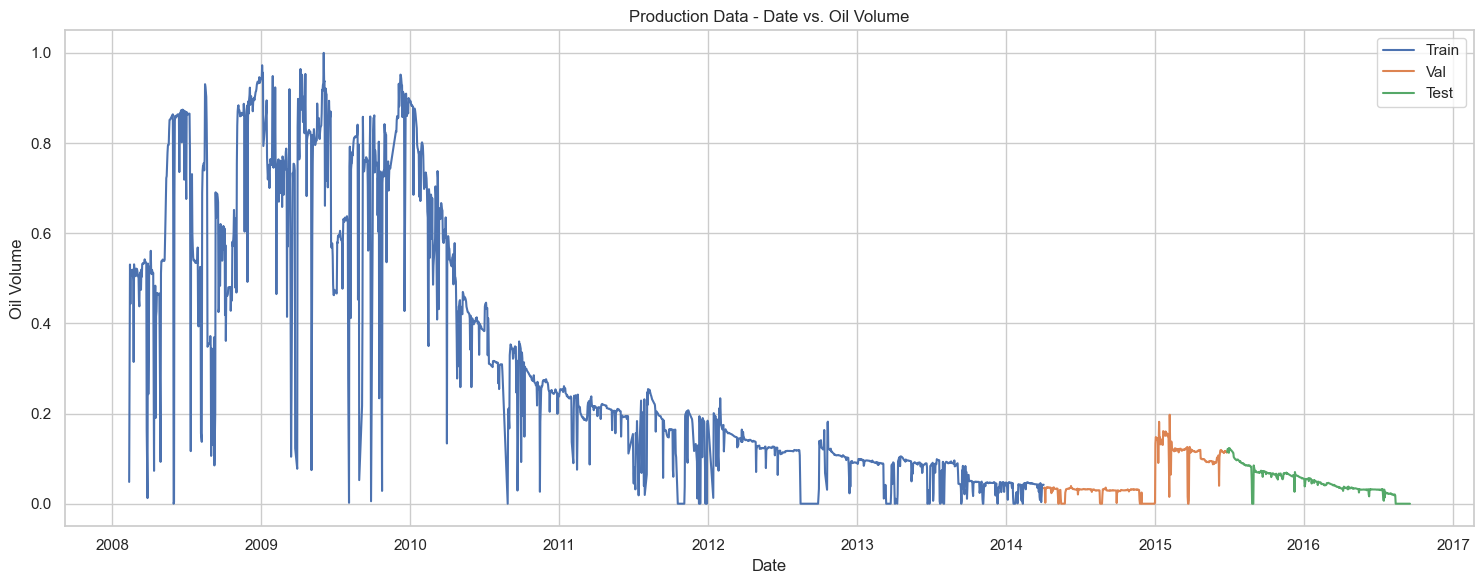

In [185]:
plt.figure(figsize=(15, 6))

sns.lineplot(x=data['DATEPRD'][:Y_train.shape[0]].ravel(), y=Y_train.ravel(), label='Train', errorbar=None)
sns.lineplot(x=data['DATEPRD'][Y_train.shape[0]:Y_train.shape[0] + Y_val.shape[0]].ravel(), y=Y_val.ravel(), label='Val', errorbar=None)
sns.lineplot(x=data['DATEPRD'][Y_train.shape[0] + Y_val.shape[0]:Y_train.shape[0] + Y_val.shape[0] + Y_test.shape[0]].ravel(), y=Y_test.ravel(), label='Test', errorbar=None)

plt.xlabel('Date')
plt.ylabel('Oil Volume')
plt.title('Production Data - Date vs. Oil Volume')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## LSTM建模

### 构造时间窗数据

将时序数据转换为适合时间序列预测任务的窗口化数据集.这是长短期记忆网络（LSTM）的主要概念。 

我们的数据将会是： 
* 前一天的所有特征（包括石油产量），当天的目标值（石油产量） 
* 然后是当天的所有特征，次日的目标值（石油产量）
* 以此类推……

In [186]:
class TimeSeriesDataset(Dataset):
    def __init__(self, features_np, target_np, window_size):
        self.features_full = torch.tensor(features_np, dtype=torch.float32)
        self.target_col = torch.tensor(target_np, dtype=torch.float32)
        if self.target_col.ndim == 1:
            self.target_col = self.target_col.unsqueeze(1)

        self.window_size = window_size
        self.X_sequences = []
        self.y_targets = []

        if len(features_np) > window_size: # 确保有足够数据创建至少一个窗口
            for i in range(len(features_np) - window_size):
                self.X_sequences.append(self.features_full[i : i + self.window_size]) # 输入序列
                self.y_targets.append(self.target_col[i + self.window_size]) # 目标值：下一个时间步的石油产量
            
            if self.X_sequences:
                self.X_sequences = torch.stack(self.X_sequences)
                self.y_targets = torch.stack(self.y_targets)
            else:
                num_features = self.features_full.shape[1] if self.features_full.ndim > 1 and self.features_full.shape[0] > 0 else 0
                target_dim_single_step = self.target_col.shape[1] if self.target_col.ndim > 1 and self.target_col.shape[0] > 0 else 0
                self.X_sequences = torch.empty(0, self.window_size, num_features, dtype=torch.float32)
                self.y_targets = torch.empty(0, target_dim_single_step, dtype=torch.float32)
        else:
            num_features = self.features_full.shape[1] if self.features_full.ndim > 1 and self.features_full.shape[0] > 0 else 0
            target_dim_single_step = self.target_col.shape[1] if self.target_col.ndim > 1 and self.target_col.shape[0] > 0 else 0
            self.X_sequences = torch.empty(0, self.window_size, num_features, dtype=torch.float32)
            self.y_targets = torch.empty(0, target_dim_single_step, dtype=torch.float32)


    def __len__(self):
        return len(self.X_sequences)

    def __getitem__(self, idx):
        return self.X_sequences[idx], self.y_targets[idx]

def create_dataloader(features_np, target_np, window_size, batch_size, shuffle=True):
    dataset = TimeSeriesDataset(features_np, target_np, window_size)
    if len(dataset) == 0:
        print(f"警告: 从长度为 {len(features_np)} 的 features_np 和窗口大小 {window_size} 创建的数据集为空。")
        return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return dataloader


In [187]:
window_size = 5 # 时间窗口大小
batch_size = 32 # 批量大小

train_loader = create_dataloader(X_train_np, Y_train_np, window_size, batch_size, shuffle=True)
val_loader = create_dataloader(X_val_np, Y_val_np, window_size, batch_size, shuffle=False)
test_loader = create_dataloader(X_test_np, Y_test_np, window_size, batch_size, shuffle=False)

# 验证 DataLoader 的形状
if len(train_loader) > 0:
    data_iter = iter(train_loader)
    try:
        first_batch_features, first_batch_target = next(data_iter)
        print(f"特征批量形状 (PyTorch): {first_batch_features.shape}")
        print(f"目标批量形状 (PyTorch): {first_batch_target.shape}")
    except StopIteration:
        print("训练加载器创建后为空。")
else:
    print("训练加载器为空，无法检查形状。")

特征批量形状 (PyTorch): torch.Size([32, 5, 10])
目标批量形状 (PyTorch): torch.Size([32, 1])


### 定义模型

#### BaseLine Model

In [188]:
class PyTorchLSTMBaseline(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, dropout_prob=0.5):
        super().__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_size1, batch_first=True) # 对应 tf.keras.layers.LSTM(128, return_sequences=True)
        self.dropout1 = nn.Dropout(dropout_prob)
        self.lstm2 = nn.LSTM(hidden_size1, hidden_size2, batch_first=True) # 对应 tf.keras.layers.LSTM(64)
        self.dropout2 = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_size2, output_size) # 对应 tf.keras.layers.Dense(1)

        # 初始化遗忘门偏置
        for name, param in self.lstm1.named_parameters():
            if 'bias' in name:
                n = param.size(0)
                start, end = n // 4, n // 2
                param.data[start:end].fill_(1.)
        for name, param in self.lstm2.named_parameters():
            if 'bias' in name:
                n = param.size(0)
                start, end = n // 4, n // 2
                param.data[start:end].fill_(1.)

    def forward(self, x):
        lstm1_out, _ = self.lstm1(x)
        dropped_out1 = self.dropout1(lstm1_out)
        _, (hn2, _) = self.lstm2(dropped_out1) # 第二个LSTM最后一个时间步的隐藏状态
        last_time_step_out = hn2[-1] # 对于单层LSTM，hn2[-1] 即为最后一个时间步的隐藏状态
        dropped_out2 = self.dropout2(last_time_step_out)
        out = self.fc(dropped_out2)
        return out

In [189]:
input_dim = features_np.shape[1]
hidden_dim1 = 128
hidden_dim2 = 64
output_dim = 1
dropout_prob = 0.5

model_pt = PyTorchLSTMBaseline(input_dim, hidden_dim1, hidden_dim2, output_dim, dropout_prob).to(device)
print(model_pt)

PyTorchLSTMBaseline(
  (lstm1): LSTM(10, 128, batch_first=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (lstm2): LSTM(128, 64, batch_first=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


## 模型训练

In [190]:
class EarlyStoppingPyTorch: # 早停法
    def __init__(self, patience=5, verbose=False, delta=0, path='pytorch_checkpoint.pt', trace_func=print):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                self.trace_func(f'早停计数器: {self.counter} / {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            self.trace_func(f'验证损失减小 ({self.val_loss_min:.6f} --> {val_loss:.6f}). 保存模型 ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [191]:
epochs = 1000
learning_rate = 0.0001
optimizer = optim.Adam(model_pt.parameters(), lr=learning_rate)
criterion = nn.MSELoss()
early_stopping_pt = EarlyStoppingPyTorch(patience=125, verbose=True, path='pytorch_lstm_baseline_best.pt')

train_losses_pt = []
val_losses_pt = []

for epoch in range(epochs):
    model_pt.train()
    running_train_loss = 0.0
    if len(train_loader) == 0:
        print("训练 DataLoader 为空，跳过此轮。")
        break
    for features_batch, target_batch in train_loader:
        features_batch, target_batch = features_batch.to(device), target_batch.to(device)
        optimizer.zero_grad()
        outputs = model_pt(features_batch)
        loss = criterion(outputs, target_batch)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item() * features_batch.size(0)
    epoch_train_loss = running_train_loss / len(train_loader.dataset) if len(train_loader.dataset) > 0 else 0
    train_losses_pt.append(epoch_train_loss)

    model_pt.eval()
    running_val_loss = 0.0
    if len(val_loader) == 0:
        print("验证 DataLoader 为空。")
        epoch_val_loss = float('inf')
    else:
        with torch.no_grad():
            for features_batch, target_batch in val_loader:
                features_batch, target_batch = features_batch.to(device), target_batch.to(device)
                outputs = model_pt(features_batch)
                loss = criterion(outputs, target_batch)
                running_val_loss += loss.item() * features_batch.size(0)
        epoch_val_loss = running_val_loss / len(val_loader.dataset) if len(val_loader.dataset) > 0 else float('inf')
    val_losses_pt.append(epoch_val_loss)
    print(f"轮次 {epoch+1}/{epochs} - 训练损失: {epoch_train_loss:.6f}, 验证损失: {epoch_val_loss:.6f}")

    if len(val_loader) > 0:
        early_stopping_pt(epoch_val_loss, model_pt)
        if early_stopping_pt.early_stop:
            print("触发早停")
            model_pt.load_state_dict(torch.load('pytorch_lstm_baseline_best.pt'))
            break
    elif epoch > early_stopping_pt.patience and len(train_losses_pt) > early_stopping_pt.patience and \
         all(epoch_train_loss >= tl - early_stopping_pt.delta for tl in train_losses_pt[-early_stopping_pt.patience:]): # 备用早停策略
        print("备用早停: 训练损失长时间未改善。")
        break

history_pt = {'loss': train_losses_pt, 'val_loss': val_losses_pt}

轮次 1/1000 - 训练损失: 0.104935, 验证损失: 0.054114
验证损失减小 (inf --> 0.054114). 保存模型 ...
轮次 2/1000 - 训练损失: 0.043395, 验证损失: 0.018240
验证损失减小 (0.054114 --> 0.018240). 保存模型 ...
轮次 3/1000 - 训练损失: 0.030363, 验证损失: 0.009215
验证损失减小 (0.018240 --> 0.009215). 保存模型 ...
轮次 4/1000 - 训练损失: 0.026727, 验证损失: 0.008497
验证损失减小 (0.009215 --> 0.008497). 保存模型 ...
轮次 5/1000 - 训练损失: 0.024477, 验证损失: 0.005740
验证损失减小 (0.008497 --> 0.005740). 保存模型 ...
轮次 6/1000 - 训练损失: 0.022433, 验证损失: 0.002496
验证损失减小 (0.005740 --> 0.002496). 保存模型 ...
轮次 7/1000 - 训练损失: 0.020994, 验证损失: 0.003266
早停计数器: 1 / 125
轮次 8/1000 - 训练损失: 0.019076, 验证损失: 0.001586
验证损失减小 (0.002496 --> 0.001586). 保存模型 ...
轮次 9/1000 - 训练损失: 0.018509, 验证损失: 0.001319
验证损失减小 (0.001586 --> 0.001319). 保存模型 ...
轮次 10/1000 - 训练损失: 0.016848, 验证损失: 0.001242
验证损失减小 (0.001319 --> 0.001242). 保存模型 ...
轮次 11/1000 - 训练损失: 0.016185, 验证损失: 0.001176
验证损失减小 (0.001242 --> 0.001176). 保存模型 ...
轮次 12/1000 - 训练损失: 0.015282, 验证损失: 0.002314
早停计数器: 1 / 125
轮次 13/1000 - 训练损失: 0.015485, 验证损失: 0.001617
早停

c:\Users\luofei\miniconda3\envs\dl\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 36718 (\N{CJK UNIFIED IDEOGRAPH-8F6E}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\luofei\miniconda3\envs\dl\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\luofei\miniconda3\envs\dl\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 25439 (\N{CJK UNIFIED IDEOGRAPH-635F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\luofei\miniconda3\envs\dl\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 22833 (\N{CJK UNIFIED IDEOGRAPH-5931}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\luofei\miniconda3\envs\dl\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 35757 (\N{CJK UNIFIED IDEOGRAPH-8BAD}) missing f

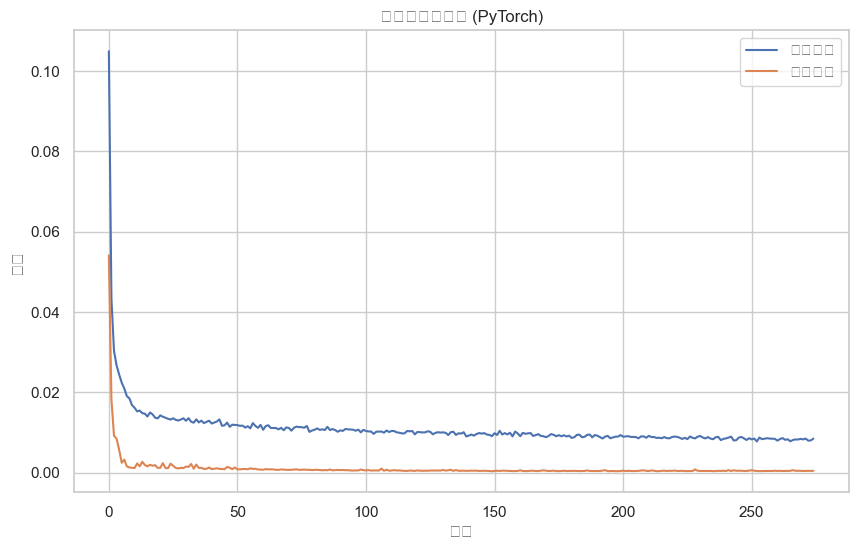

In [192]:
# 绘图：训练损失和验证损失
plt.figure(figsize=(10, 6))
plt.plot(history_pt['loss'], label='训练损失')
if any(v != float('inf') for v in history_pt['val_loss']):
    plt.plot(history_pt['val_loss'], label='验证损失')
plt.title('训练和验证损失 (PyTorch)')
plt.xlabel('轮次')
plt.ylabel('损失')
plt.legend()
plt.grid(True)
plt.show()

### 评估与预测

In [193]:
model_pt.load_state_dict(torch.load('pytorch_lstm_baseline_best.pt'))
model_pt.eval()
all_predictions_pt = []
num_test_predictions = 0

if len(test_loader) > 0:
    with torch.no_grad():
        for features_batch, _ in test_loader:
            features_batch = features_batch.to(device)
            outputs = model_pt(features_batch)
            all_predictions_pt.append(outputs.cpu().numpy())
    if all_predictions_pt:
        predictions_pt_np = np.concatenate(all_predictions_pt, axis=0)
        num_test_predictions = predictions_pt_np.shape[0]
    else:
        predictions_pt_np = np.array([])
else:
    print("测试 DataLoader 为空，不进行预测。")
    predictions_pt_np = np.array([])

In [194]:
# 逆变换预测结果
df_final_pt = pd.DataFrame()
if predictions_pt_np.size > 0:
    num_actual_test_targets = len(Y_test_np) - window_size
    if num_test_predictions == num_actual_test_targets:
        X_test_features_for_inverse = X_test_np[window_size:window_size + num_test_predictions, :-1]
        if predictions_pt_np.ndim == 1:
            predictions_pt_np = predictions_pt_np.reshape(-1,1)
        data_for_inverse_transform = np.concatenate([X_test_features_for_inverse, predictions_pt_np], axis=1)
        df_pred_for_inverse = pd.DataFrame(data_for_inverse_transform, columns=columns_to_scale)
        rev_trans_pt = scaler.inverse_transform(df_pred_for_inverse.to_numpy())
        
        original_test_start_index = X_train_np.shape[0] + X_val_np.shape[0]
        df_final_start_index = original_test_start_index + window_size
        df_final_end_index = df_final_start_index + num_test_predictions
        df_final_pt = data.iloc[df_final_start_index:df_final_end_index].copy()

        if len(df_final_pt) == num_test_predictions:
            df_final_pt['PREDICTED_OIL'] = rev_trans_pt[:, -1]
        else:
            print(f"df_final_pt 行数不匹配。预期 {num_test_predictions}, 得到 {len(df_final_pt)}")
            df_final_pt = pd.DataFrame()
    else:
        print(f"预测数量 ({num_test_predictions}) 与实际目标数量 ({num_actual_test_targets}) 不符。")
else:
    print("未生成预测。")

In [195]:
if not df_final_pt.empty and 'BORE_OIL_VOL' in df_final_pt.columns and 'PREDICTED_OIL' in df_final_pt.columns:
    y_true_pt = df_final_pt['BORE_OIL_VOL']
    y_pred_pt = df_final_pt['PREDICTED_OIL']

    mse_pt = mean_squared_error(y_true_pt, y_pred_pt)
    mae_pt = mean_absolute_error(y_true_pt, y_pred_pt)
    rmse_pt = np.sqrt(mse_pt)
    r2_pt = r2_score(y_true_pt, y_pred_pt)

    print(f"PyTorch 模型 - 均方误差 (MSE): {mse_pt}")
    print(f"PyTorch 模型 - 平均绝对误差 (MAE): {mae_pt}")
    print(f"PyTorch 模型 - 均方根误差 (RMSE): {rmse_pt}")
    print(f"PyTorch 模型 - R方 (R²): {r2_pt}")
else:
    print("df_final_pt 为空或缺少必要列，无法计算指标。")

PyTorch 模型 - 均方误差 (MSE): 3610.193321883419
PyTorch 模型 - 平均绝对误差 (MAE): 40.85125739510348
PyTorch 模型 - 均方根误差 (RMSE): 60.08488430448559
PyTorch 模型 - R方 (R²): 0.8565494096858024


c:\Users\luofei\miniconda3\envs\dl\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\luofei\miniconda3\envs\dl\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 26399 (\N{CJK UNIFIED IDEOGRAPH-671F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\luofei\miniconda3\envs\dl\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 30707 (\N{CJK UNIFIED IDEOGRAPH-77F3}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\luofei\miniconda3\envs\dl\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 27833 (\N{CJK UNIFIED IDEOGRAPH-6CB9}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\luofei\miniconda3\envs\dl\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20135 (\N{CJK UNIFIED IDEOGRAPH-4EA7}) missing f

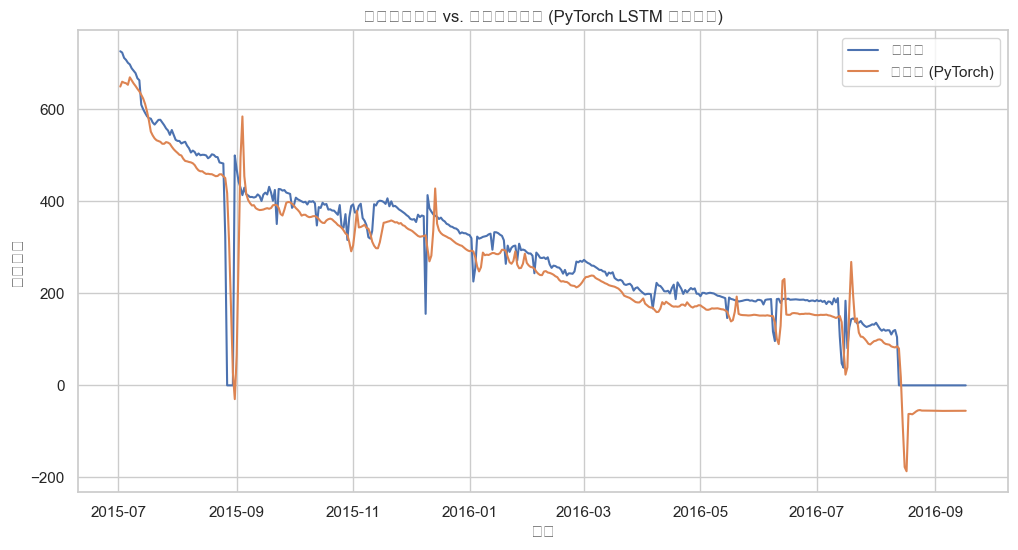


实际值与预测值对比 (PyTorch):
        DATEPRD  BORE_OIL_VOL  PREDICTED_OIL
4523 2015-07-02        726.33     649.551754
4524 2015-07-03        723.42     660.124549
4525 2015-07-04        711.93     657.968923
4526 2015-07-05        707.58     656.826835
4527 2015-07-06        701.27     653.449183


In [196]:
if not df_final_pt.empty and 'DATEPRD' in df_final_pt.columns and 'BORE_OIL_VOL' in df_final_pt.columns and 'PREDICTED_OIL' in df_final_pt.columns:
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df_final_pt, x='DATEPRD', y='BORE_OIL_VOL', label='实际值', errorbar=None)
    sns.lineplot(data=df_final_pt, x='DATEPRD', y='PREDICTED_OIL', label='预测值 (PyTorch)', errorbar=None)
    plt.xlabel('日期')
    plt.ylabel('石油产量')
    plt.title('实际石油产量 vs. 预测石油产量 (PyTorch LSTM 基线模型)')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("df_final_pt 为空或缺少列，跳过最终绘图。")

if not df_final_pt.empty:
    compare_data_pt = df_final_pt[['DATEPRD', 'BORE_OIL_VOL', 'PREDICTED_OIL']]
    print("\n实际值与预测值对比 (PyTorch):")
    print(compare_data_pt.head())
else:
    print("没有最终对比数据可显示。")